In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import json
import datetime
import matplotlib.pyplot as plt
import os
parent_dir = os.path.dirname(os.getcwd())
path = parent_dir 
save_path = parent_dir + '/'
from optimization import *
import warnings
warnings.filterwarnings("ignore")
color_palette = ['#332288',  '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255']

## Figure 6: Calculate and plot NPC for all vehicles

In [ ]:
aging = 'batt_aging_0'
period_string = '2024-06-03_to_2025-06-01'

In [ ]:
def load_results(results_path, period_string):
    '''Loads results into matrices'''
    cost_mat_uncontrolled = []
    cost_mat_controlled = []
    cost_mat_v2g_home = []
    cost_mat_v2g_everywhere = []

    for vin in np.arange(1,749):
        try:
            cost_mat_uncontrolled.append( pd.read_csv(results_path + 'cost_uncontrolled_' + period_string + '_vin_' +str(vin) + '.csv').iloc[:,1])
            cost_mat_controlled.append( pd.read_csv(results_path + 'cost_no_v2g_' + period_string + '_vin_' +str(vin) + '.csv').iloc[:,1])
            cost_mat_v2g_home.append( pd.read_csv(results_path + 'cost_v2g_home_' + period_string + '_vin_' +str(vin) + '.csv').iloc[:,1])
            cost_mat_v2g_everywhere.append(pd.read_csv(results_path + 'cost_v2g_everywhere_' + period_string + '_vin_' +str(vin) + '.csv').iloc[:,1])

        except:
            pass

    cost_mat_uncontrolled = np.array(cost_mat_uncontrolled)
    cost_mat_controlled = np.array(cost_mat_controlled)
    cost_mat_v2g_home = np.array(cost_mat_v2g_home)
    cost_mat_v2g_everywhere = np.array(cost_mat_v2g_everywhere)

    #replace nan with previous value
    for vin in np.arange(cost_mat_controlled.shape[0]):
        for week in np.arange(cost_mat_controlled.shape[1]):
            if np.isnan(cost_mat_controlled[vin, week]):
                if week == 0:
                    cost_mat_controlled[vin, week] = 0
                else:
                    cost_mat_controlled[vin, week] = cost_mat_controlled[vin, week-1]
            if np.isnan(cost_mat_uncontrolled[vin, week]):
                if week == 0:
                    cost_mat_uncontrolled[vin, week] = 0
                else:
                    cost_mat_uncontrolled[vin, week] = cost_mat_uncontrolled[vin, week-1]
            if np.isnan(cost_mat_v2g_home[vin, week]):
                if week == 0:
                    cost_mat_v2g_home[vin, week] = 0
                else:
                    cost_mat_v2g_home[vin, week] = cost_mat_v2g_home[vin, week-1]
            if np.isnan(cost_mat_v2g_everywhere[vin, week]):
                if week == 0:
                    cost_mat_v2g_everywhere[vin, week] = 0
                else:
                    cost_mat_v2g_everywhere[vin, week] = cost_mat_v2g_everywhere[vin, week-1]


    #delete rows that sum up to zero from controlled
    zero_idx = np.all(cost_mat_controlled == 0, axis=1)
    cost_mat_controlled = cost_mat_controlled[~zero_idx]
    cost_mat_v2g_home = cost_mat_v2g_home[~zero_idx]
    cost_mat_v2g_everywhere = cost_mat_v2g_everywhere[~zero_idx]

    return cost_mat_uncontrolled, cost_mat_controlled, cost_mat_v2g_home, cost_mat_v2g_everywhere

In [4]:
def plot_npc(ax, periods, npv_uncontrolled, npv_controlled, npv_v2g_low, npv_v2g_medium, npv_v2g_high, circuit, breakeven_years=None, breakeven_costs=None):
    
    color_dark = "#437A98" #70A3BF'
    color_light = "#B2E0F4"
    ax.plot(np.mean(npv_uncontrolled, axis=0), color = color_palette[0], label='Baseline')
    ax.plot(np.mean(npv_controlled, axis=0), color = color_palette[1], label='Managed')
    if breakeven_years is not None and breakeven_costs is not None:
        ax.scatter(breakeven_years, breakeven_costs,color='black', s=40, zorder=3, label='Breakeven Points')
    else:
        ax.plot(0,0, linestyle='none', marker='none', label=' ')
    ax.plot(np.mean(npv_v2g_low, axis=0), color = color_light, label='V2G - Low Cap. Cost', linestyle='--', linewidth=2)
    ax.plot(np.mean(npv_v2g_medium, axis=0), color = color_palette[3], label='V2G - Medium Cap. Cost')
    ax.plot(np.mean(npv_v2g_high, axis=0), color = color_dark, label='V2G - High Cap. Cost', linestyle='-.')
    ax.fill_between(np.arange(0, 52*periods), np.mean(npv_uncontrolled, axis=0) - np.nanstd(npv_uncontrolled, axis=0), np.mean(npv_uncontrolled, axis=0) + np.std(npv_uncontrolled, axis=0), color = color_palette[0],  alpha=0.1)
    ax.fill_between(np.arange(0, 52*periods), np.nanmean(npv_controlled, axis=0) - np.nanstd(npv_controlled, axis=0), np.nanmean(npv_controlled, axis=0) + np.nanstd(npv_controlled, axis=0), color = color_palette[1], alpha=0.1)
    ax.fill_between(np.arange(0, 52*periods), np.nanmean(npv_v2g_low, axis=0) - np.nanstd(npv_v2g_low, axis=0), np.nanmean(npv_v2g_low, axis=0) + np.nanstd(npv_v2g_low, axis=0), color = color_light, alpha=0.2)
    ax.fill_between(np.arange(0, 52*periods), np.nanmean(npv_v2g_medium, axis=0) - np.nanstd(npv_v2g_medium, axis=0), np.nanmean(npv_v2g_medium, axis=0) + np.nanstd(npv_v2g_medium, axis=0), color = color_palette[3], alpha=0.1)
    ax.fill_between(np.arange(0, 52*periods), np.nanmean(npv_v2g_high, axis=0) - np.nanstd(npv_v2g_high, axis=0), np.nanmean(npv_v2g_high, axis=0) + np.nanstd(npv_v2g_high, axis=0), color = color_dark, alpha=0.1)
   
    ax.legend(fontsize=12, loc='lower right', ncol=2)
    min=-15000
    max=30000
    ax.set_ylim(min, max)
    ax.set_yticklabels([str(int(x/1000)) for x in np.arange(min, max+1, 5000)], fontsize=14)     
    ax.set_xlim(0,10)

    #set tick params 
    ax.tick_params(axis='both', which='major', labelsize=12.5)
    ax.set_xlabel('Years', fontsize=14)
    ax.set_ylabel('Net Present Cost [$1000]', fontsize=14)
    
    #set xticks to years
    ax.set_xticks(np.arange(0, 52*periods +1, 52 *2))
    ax.set_xticklabels([int(x) for x in np.arange(0, periods+1, 2)])
    ax.annotate('Circuit ' + str(circuit)[-1], xy=(0.1, .90), xycoords='axes fraction', ha='center', fontsize=16)

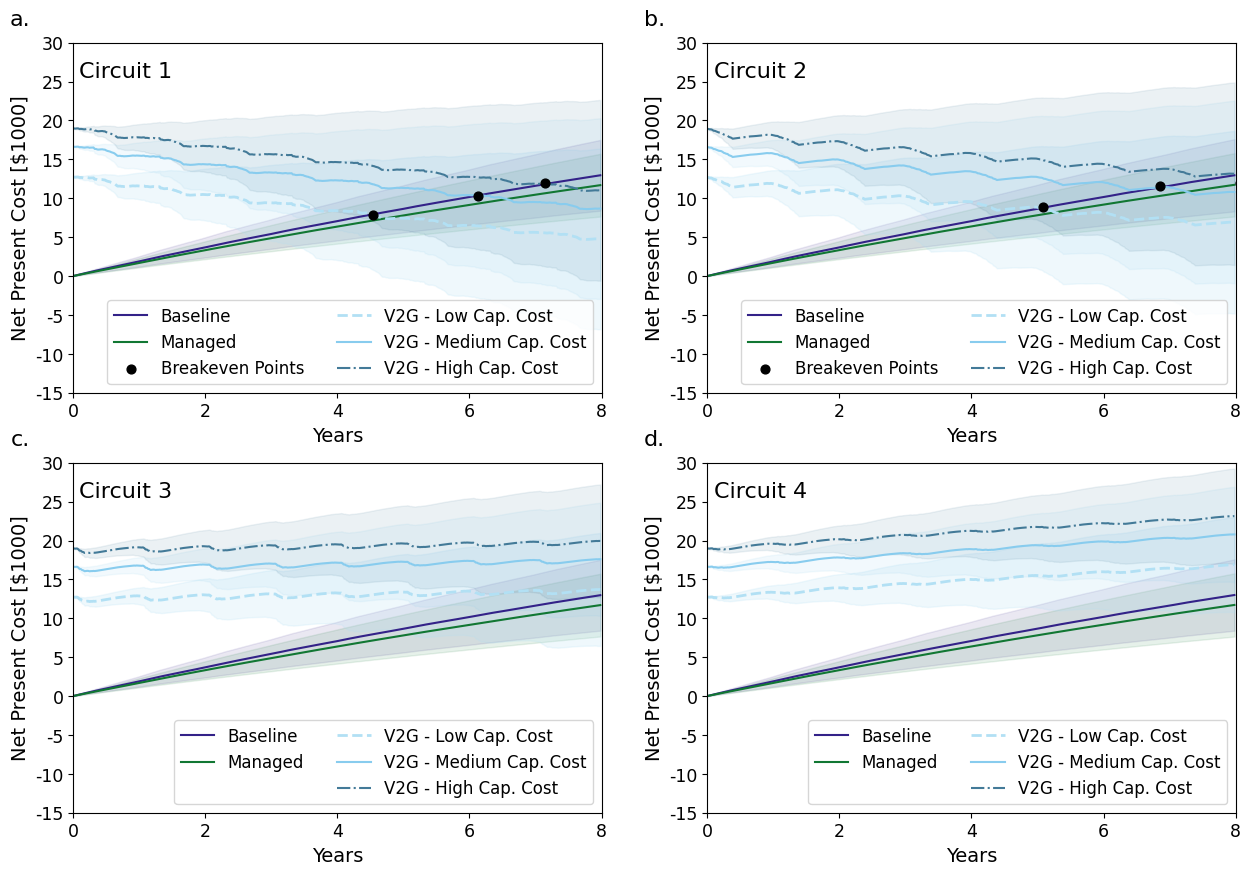

In [5]:
#npc calc, each entry is a week
years = 8 # years
discount_rate = 0.045
low_cc = 6440 + 800 + 5505 # quasar + interconnection fee + install
medium_cc = 6440 + 800 + 5505 + 3895# quasar + interconnection fee + install + energy management system
high_cc = 6440 + 800 + (5505 + 3895) * 1.25 # quasar + interconnection fee + install + energy management system * 1.2 for fee in expensive area

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()
fig_label = ['a.', 'b.', 'c.', 'd.']

circuit = 'cir_1'
results_path = 'Results/'+ circuit+ '/' + aging + '/' + 'elrp_1_'
cost_mat_uncontrolled, cost_mat_controlled, cost_mat_v2g_home, cost_mat_v2g_everywhere= load_results(results_path, period_string)

num_weeks = cost_mat_uncontrolled.shape[1]
npc_uncontrolled = np.zeros((cost_mat_uncontrolled.shape[0], num_weeks * years))
npc_controlled = np.zeros((cost_mat_controlled.shape[0],  num_weeks * years))
npc_v2g_low = np.zeros((cost_mat_v2g_home.shape[0],  num_weeks * years))
npc_v2g_medium = np.zeros((cost_mat_v2g_home.shape[0],  num_weeks * years))
npc_v2g_high = np.zeros((cost_mat_v2g_home.shape[0],  num_weeks * years))

for year in range(years):
    for week in range(52):
        if year == 0 and week == 0:
            npc_v2g_low[:,0] = low_cc + cost_mat_v2g_home[:,0]
            npc_v2g_medium[:,0] = medium_cc + cost_mat_v2g_home[:,0]
            npc_v2g_high[:,0] = high_cc + cost_mat_v2g_home[:,0]
        else:
            npc_uncontrolled[:, year * 52 + week] = npc_uncontrolled[:, year * 52 + week-1] + cost_mat_uncontrolled[:, week] / np.power(1 + discount_rate, (year * 52+week)/52)
            npc_controlled[:, year * 52 + week] = npc_controlled[:, year * 52 + week-1] + cost_mat_controlled[:, week] / np.power(1 + discount_rate, (year * 52+week)/52)
            npc_v2g_low[:, year * 52 + week] = npc_v2g_low[:, year * 52 + week-1] + cost_mat_v2g_home[:, week] / np.power(1 + discount_rate, (year * 52+week)/52)
            npc_v2g_medium[:, year * 52 + week] = npc_v2g_medium[:, year * 52 + week-1] + cost_mat_v2g_home[:, week] / np.power(1 + discount_rate, (year * 52+week)/52)
            npc_v2g_high[:, year * 52 + week] = npc_v2g_high[:, year * 52 + week-1] + cost_mat_v2g_home[:, week] / np.power(1 + discount_rate, (year * 52+week)/52)

breakeven_years = [4.54*52, 6.13*52, 7.15*52] # years
breakeven_costs = [7800, 10300, 12000] #
plot_npc(ax[0], years, npc_uncontrolled, npc_controlled, npc_v2g_low, npc_v2g_medium, npc_v2g_high, circuit, breakeven_years, breakeven_costs)
ax[0].annotate(fig_label[0], xy=(-0.1, 1.05), xycoords='axes fraction', ha='center', fontsize=16)


circuit = 'cir_2'
results_path = 'Results/'+ circuit+ '/' + aging + '/' + 'elrp_1_'
cost_mat_uncontrolled, cost_mat_controlled, cost_mat_v2g_home, cost_mat_v2g_everywhere = load_results(results_path, period_string)

num_weeks = cost_mat_uncontrolled.shape[1]
npc_uncontrolled = np.zeros((cost_mat_uncontrolled.shape[0], num_weeks * years))
npc_controlled = np.zeros((cost_mat_controlled.shape[0],  num_weeks * years))
npc_v2g_low = np.zeros((cost_mat_v2g_home.shape[0],  num_weeks * years))
npc_v2g_medium = np.zeros((cost_mat_v2g_home.shape[0],  num_weeks * years))
npc_v2g_high = np.zeros((cost_mat_v2g_home.shape[0],  num_weeks * years))

for year in range(years):
    for week in range(52):
        if year == 0 and week == 0:
            npc_v2g_low[:,0] = low_cc + cost_mat_v2g_home[:,0]
            npc_v2g_medium[:,0] = medium_cc + cost_mat_v2g_home[:,0]
            npc_v2g_high[:,0] = high_cc + cost_mat_v2g_home[:,0]
        else:
            npc_uncontrolled[:, year * 52 + week] = npc_uncontrolled[:, year * 52 + week-1] + cost_mat_uncontrolled[:, week] / np.power(1 + discount_rate, (year * 52+week)/52)
            npc_controlled[:, year * 52 + week] = npc_controlled[:, year * 52 + week-1] + cost_mat_controlled[:, week] / np.power(1 + discount_rate, (year * 52+week)/52)
            npc_v2g_low[:, year * 52 + week] = npc_v2g_low[:, year * 52 + week-1] + cost_mat_v2g_home[:, week] / np.power(1 + discount_rate, (year * 52+week)/52)
            npc_v2g_medium[:, year * 52 + week] = npc_v2g_medium[:, year * 52 + week-1] + cost_mat_v2g_home[:, week] / np.power(1 + discount_rate, (year * 52+week)/52)
            npc_v2g_high[:, year * 52 + week] = npc_v2g_high[:, year * 52 + week-1] + cost_mat_v2g_home[:, week] / np.power(1 + discount_rate, (year * 52+week)/52)

breakeven_years = [5.08  *52,  6.85  *52,  8.06 *52] # years
breakeven_costs = [8900, 11600, 11900] 
plot_npc(ax[1], years, npc_uncontrolled, npc_controlled, npc_v2g_low, npc_v2g_medium, npc_v2g_high, circuit, breakeven_years, breakeven_costs)
ax[1].annotate(fig_label[1], xy=(-0.1, 1.05), xycoords='axes fraction', ha='center', fontsize=16)


for i, circuit in enumerate(['cir_3', 'cir_4']):
    results_path = 'Results/'+ circuit+ '/' + aging + '/' + 'elrp_1_'
    cost_mat_uncontrolled, cost_mat_controlled, cost_mat_v2g_home, cost_mat_v2g_everywhere = load_results(results_path, period_string)

    num_weeks = cost_mat_uncontrolled.shape[1]
    npc_uncontrolled = np.zeros((cost_mat_uncontrolled.shape[0], num_weeks * years))
    npc_controlled = np.zeros((cost_mat_controlled.shape[0],  num_weeks * years))
    npc_v2g_low = np.zeros((cost_mat_v2g_home.shape[0],  num_weeks * years))
    npc_v2g_medium = np.zeros((cost_mat_v2g_home.shape[0],  num_weeks * years))
    npc_v2g_high = np.zeros((cost_mat_v2g_home.shape[0],  num_weeks * years))

    for year in range(years):
        for week in range(52):
            if year == 0 and week == 0:
                npc_v2g_low[:,0] = low_cc + cost_mat_v2g_home[:,0]
                npc_v2g_medium[:,0] = medium_cc + cost_mat_v2g_home[:,0]
                npc_v2g_high[:,0] = high_cc + cost_mat_v2g_home[:,0]
            else:
                npc_uncontrolled[:, year * 52 + week] = npc_uncontrolled[:, year * 52 + week-1] + cost_mat_uncontrolled[:, week] / np.power(1 + discount_rate,(year * 52+week)/52)
                npc_controlled[:, year * 52 + week] = npc_controlled[:, year * 52 + week-1] + cost_mat_controlled[:, week] / np.power(1 + discount_rate, (year * 52+week)/52)
                npc_v2g_low[:, year * 52 + week] = npc_v2g_low[:, year * 52 + week-1] + cost_mat_v2g_home[:, week] / np.power(1 + discount_rate, (year * 52+week)/52)
                npc_v2g_medium[:, year * 52 + week] = npc_v2g_medium[:, year * 52 + week-1] + cost_mat_v2g_home[:, week] / np.power(1 + discount_rate, (year * 52+week)/52)
                npc_v2g_high[:, year * 52 + week] = npc_v2g_high[:, year * 52 + week-1] + cost_mat_v2g_home[:, week] / np.power(1 + discount_rate, (year * 52+week)/52)

    plot_npc(ax[i+2], years, npc_uncontrolled, npc_controlled, npc_v2g_low, npc_v2g_medium, npc_v2g_high, circuit)
    ax[i+2].annotate(fig_label[i+2], xy=(-0.1, 1.05), xycoords='axes fraction', ha='center', fontsize=16)

plt.savefig(save_path + '6_npc_no_clusters.pdf', bbox_inches='tight')
